In [1]:
import sys
import math
import copy
import json
import time
import random
import itertools
import numpy as np
import pandas as pd
import urllib.request
from hashlib import new
from sklearn.cluster import KMeans
from py2opt.routefinder import RouteFinder
import matplotlib.pyplot as plt

In [2]:
start_time = time.time()

In [3]:
# bus_combis.py

# for pre-optimization
def get_min_and_max_no_of_clusters(buses, data):
    bus_capacity_list = []
    for bus in buses:
        bus_capacity_list.append(bus['capacity'])
    bus_capacity_list.sort()

    passengers = len(data)
    min_cluster = math.ceil(passengers / bus_capacity_list[-1])
    max_cluster = math.ceil(passengers / bus_capacity_list[0])
    
    return min_cluster, max_cluster


# for pre-optimization
def get_bus_capacities(buses):
    bus_capacities = []
    for bus in buses:
        bus_capacities.append(bus['capacity'])
    bus_capacities.sort()
    
    return bus_capacities


# for pre-optimization
def get_min_and_max_no_of_clusters(total_passengers, bus_capacities):
    min_cluster = math.ceil(total_passengers / bus_capacities[-1])
    max_cluster = math.ceil(total_passengers / bus_capacities[0])
    
    return min_cluster, max_cluster


# for pre-optimization
def get_bus_combis_without_sorting(min_cluster, max_cluster, total_passengers, bus_capacities):
    bus_combinations_before_sorting_by_cost = {}

    for i in range(min_cluster, max_cluster + 1):
        n_cluster = i
        bus_combis_for_n_cluster = []
        for combination in itertools.combinations_with_replacement(bus_capacities, n_cluster):
            if sum(combination) > total_passengers:
                bus_combis_for_n_cluster.append(combination)

        bus_combinations_before_sorting_by_cost[i] = bus_combis_for_n_cluster
        
    return bus_combinations_before_sorting_by_cost


# for pre-optimization
# compile the cost of all the bus combis into a dict for sorting later
def get_cost_dictionary(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses):
    cost_dictionary = {}

    for i in range(min_cluster, max_cluster + 1):
        bus_combis_for_current_n_of_cluster = bus_combis_before_sorting_by_cost[i]
        current_cost_dictionary_for_current_n_of_cluster = {}
        for j in range(len(bus_combis_for_current_n_of_cluster)):
            current_combi = bus_combis_for_current_n_of_cluster[j]
            current_cost = 0
            for current_bus_capacity in current_combi:
                for bus in buses:
                    if current_bus_capacity == bus['capacity']:
                        current_cost += bus['price_per_hour']
            current_cost_dictionary_for_current_n_of_cluster[j] = current_cost
        cost_dictionary[i] = current_cost_dictionary_for_current_n_of_cluster
                    
    return cost_dictionary


# for pre-optimization
def sort_cost_dictionary(cost_dictionary, min_cluster, max_cluster):
    sorted_cost_dictionary = {}
    for i in range(min_cluster, max_cluster + 1):
        sorted_cost_dict = sorted(cost_dictionary[i].items(), key=lambda x: x[1])
        sorted_cost_dictionary[i] = sorted_cost_dict
    return sorted_cost_dictionary


# for pre-optimization
def get_sorted_bus_combis(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses):
    cost_dictionary = get_cost_dictionary(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses)
    sorted_cost_dictionary = sort_cost_dictionary(cost_dictionary, min_cluster, max_cluster)
    
    bus_combinations = {}
    for i in range(min_cluster, max_cluster + 1):
        # for current_n of cluster 
        bus_combi = []
        sorted_cost_list_of_bus_combi = sorted_cost_dictionary[i]
        for index_and_cost in sorted_cost_list_of_bus_combi:
            index = index_and_cost[0]
            bus_combi.append(bus_combis_before_sorting_by_cost[i][index])

        bus_combinations[i] = bus_combi      

    return bus_combinations


# for pre-optimization
def get_bus_combi_for_one_n_cluster(no_of_clusters, sorted_no_of_people, total_passengers, buses, bus_capacities):
    
    # bus combis without sorting
    bus_combis_for_n_cluster = []
    for combination in itertools.combinations_with_replacement(bus_capacities, no_of_clusters):
        if sum(combination) > total_passengers:
            bus_combis_for_n_cluster.append(combination)
        
    # cost dictionary without sorting
    current_cost_dictionary = {}
    for i in range(len(bus_combis_for_n_cluster)):
        current_combi = bus_combis_for_n_cluster[i]
        current_cost = get_cost_of_one_bus_combination_without_duration(buses, current_combi)
        current_cost_dictionary[i] = current_cost
    
    # sort cost dictionary
    sorted_cost_dict = sorted(current_cost_dictionary.items(), key=lambda x: x[1])
    
    sorted_bus_combis = []
    for index_and_cost in sorted_cost_dict:
        index = index_and_cost[0]
        sorted_bus_combis.append(bus_combis_for_n_cluster[index])
    
    for sorted_bus_combi in sorted_bus_combis:
        if all(x < y for x, y in zip(tuple(sorted_no_of_people), sorted_bus_combi)):
            return sorted_bus_combi
        
    return None
    

# bus capacities are alraedy sorted from smallest to biggest
def get_smallest_bus_for_given_no_of_passengers(bus_capacities, no_of_passengers):
    for cap in bus_capacities:
        if no_of_passengers <= cap:
            return cap
        

# get cost of one bus combination
def get_cost_of_one_bus_combination_without_duration(buses, bus_combi):
    cost = 0
    for current_bus_capacity in bus_combi:
        for bus in buses:
            if current_bus_capacity == bus['capacity']:
                cost += bus['price_per_hour']
                break
    return cost


# get cost of one bus, taking into consideration its duration
def get_cost_of_a_bus_with_duration(bus_capacity, duration_in_min, buses):
    for bus in buses:
        if bus_capacity == bus['capacity']:
            cost = bus['price_per_hour'] * math.ceil(duration_in_min / 60)
            return cost

In [4]:
# coordinates.py

def get_coords_of_single_location(coordinates, keyword):
    keyword = keyword.lower()
    search = coordinates.copy()
    search = search[search["station_name"].notna()]
    search["station_name"] = search["station_name"].str.lower()
    result = search[search["station_name"].str.contains(keyword)].iloc[0]
    return [
        result["latitude"],
        result["longitude"]
    ]

In [5]:
# cost.py

# calculate costs for only one bus combination
def get_cost_of_one_bus_combi(bus_sizes_tuple, bus_durations_tuple, buses): # e.g. (27,33)
    cost = 0

    for i in range(len(bus_sizes_tuple)):
        
        for bus in buses:
            if bus_sizes_tuple[i] == bus['capacity']:
                # add the costs based on the sizes and durations of buses used
                no_of_minutes = bus_durations_tuple[i]
                no_of_hours = math.ceil(no_of_minutes / 60)
                cost += bus['price_per_hour'] * no_of_hours

    return cost


# for pre-optimization
# calculate costs for only one bus combination, and also convert the bus_durations_tuple from seconds to minutes
def get_cost_and_durations_in_mins_of_one_bus_combi(bus_sizes_tuple, bus_durations_tuple, buses): # e.g. (27,33)
    cost = 0
    new_duration_in_mins = []
    
    for i in range(len(bus_sizes_tuple)):
        for bus in buses:
            if bus_sizes_tuple[i] == bus['capacity']:
                # set the new durations to be in minutes
                bus_durations_tuple[i] = math.ceil(bus_durations_tuple[i] / 60)
                new_duration_in_mins.append(bus_durations_tuple[i])

                # add the costs based on the sizes and durations of buses used
                no_of_minutes = bus_durations_tuple[i]
                no_of_hours = math.ceil(no_of_minutes / 60)
                cost += bus['price_per_hour'] * no_of_hours

    return cost, new_duration_in_mins


# for pre-optimization
# calculate costs for each of the different numbers of clusters
def get_cost_and_durations_in_mins(tsp_durations, chosen_bus_combis, buses):
    default_costs = []
    durations_in_minutes = []
    
    copy_of_durations = copy.deepcopy(tsp_durations)
    
    for i in range(len(chosen_bus_combis)):
        cost, durations_in_min = get_cost_and_durations_in_mins_of_one_bus_combi(chosen_bus_combis[i], copy_of_durations[i], buses)
            
        default_costs.append(cost)
        durations_in_minutes.append(durations_in_min)
    
    return default_costs, durations_in_minutes

In [6]:
# data_processing.py

# for pre-optimization
def get_data_consolidated(data, final_venue):
    data_numbers = {}
    # {'Tuas Crescent MRT Station': 6,
    #  'Pioneer MRT Station': 18,}

    data_coordinates = {}
    # {'Tuas Crescent MRT Station': ['1.32102695188066', '103.649078232635'],
    #  'Pioneer MRT Station': ['1.33758688240768', '103.697321513018']}

    data_list = []
    # [['Tuas Crescent MRT Station', '1.32102695188066', '103.649078232635'],
    #  ['Pioneer MRT Station', '1.33758688240768', '103.697321513018']]

    for location in data:
        if data_numbers.get(location[0]) is not None:
            no_of_this_location = data_numbers[location[0]]
            no_of_this_location += 1
            data_numbers[location[0]] = no_of_this_location
        else:
            data_numbers[location[0]] = 1
            data_coordinates[location[0]] = location[1:3]
            data_list.append(location)
            
    data_list_with_final_venue = data_list.copy()
    data_list_with_final_venue.append(final_venue)
            
    return data_numbers, data_coordinates, data_list, data_list_with_final_venue


# for pre-optimization
def add_coordinates_to_locations(coordinates, data, final_venue):
    # add coordinates to locations list
    for location in data:
        coords = get_coords_of_single_location(coordinates, location[0].rpartition(' MRT')[0])
        for coord in coords:
            location.append(coord)

    # add coordinates to final venue
    final_venue_coords = get_coords_of_single_location(coordinates, final_venue[0].rpartition(' MRT')[0])
    for coord in final_venue_coords:
        final_venue.append(coord)

In [7]:
# kmeans.py

# for pre-optimization
def fit_kmeans(data, min_cluster, max_cluster, bus_combinations):
    df = pd.DataFrame(data, columns = ['mrt', 'lat', 'long'])
    df_lat_long = df.iloc[:,1:3]
    
    no_of_people_in_each_cluster = [] # to get number of people in each bus at the end
    sorted_no_of_people_in_each_cluster = [] # to get the bus combinations
    cluster_allocations_of_locations = []
    chosen_bus_combis = []
    chosen_bus_combis_indexes = []
    selected_cluster_sizes = []

    for i in range(min_cluster, max_cluster + 1):

        # all possible bus combis
        n_bus_cluster_combi = bus_combinations[i]

        # run KMeans
        clf = KMeans(n_clusters = i)
        clf.fit_predict(df_lat_long)
        clf = clf.labels_

        # get the sizes of clusters
        kmeans_pred_cluster = []
        for j in range(i):
            kmeans_pred_cluster.append(np.count_nonzero(clf == j))
        sorted_kmeans_pred_cluster = sorted(kmeans_pred_cluster)

        # find the bus combination for this cluster size and add to overall bus combis list
        for j in range(len(n_bus_cluster_combi)):
            chosen_bus_combi = n_bus_cluster_combi[j]
            if all(x < y for x, y in zip(tuple(sorted_kmeans_pred_cluster), chosen_bus_combi)):

                # if there is a suitable bus combi, add the results to their overall lists
                # print('{}-mean clustering for total size of'.format(i), len(data), ":", kmeans_pred_cluster)
                sorted_no_of_people_in_each_cluster.append(sorted_kmeans_pred_cluster)
                no_of_people_in_each_cluster.append(kmeans_pred_cluster)

                # print('Chosen bus combi', chosen_bus_combi)
                chosen_bus_combis.append(chosen_bus_combi)
                chosen_bus_combis_indexes.append(j)

                # print('Assigned cluster for each of the {} stations'.format(len(data)), ":", clf, "\n")
                cluster_allocations_of_locations.append(clf)    

                selected_cluster_sizes.append(i)
                break

    return sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster, cluster_allocations_of_locations, \
                chosen_bus_combis, chosen_bus_combis_indexes, selected_cluster_sizes


# for pre-optimization
# clusters are sorted starting from lowest number of passengers in each n_cluster
def get_clustered_locations_list_before_tsp(selected_cluster_sizes, cluster_allocations_of_locations, data, \
                                           sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster):
    clustered_locations_list_before_tsp = []

    for i in range(len(selected_cluster_sizes)):
        cluster = {}
        for j in range(selected_cluster_sizes[i]):
            cluster[j] = []

        # adjust cluster no such that lower no means less passengers in that cluster
        cluster_allocations_of_locations[i] = adjust_cluster_no_of_cluster_allocations_of_locations( \
            cluster_allocations_of_locations[i], sorted_no_of_people_in_each_cluster[i], no_of_people_in_each_cluster[i])

        counter = 0
        for j in cluster_allocations_of_locations[i]:
            if data[counter] not in cluster[j]:
                cluster[j].append(data[counter])
            counter += 1
            
        clustered_locations_list_before_tsp.append(cluster)

    return clustered_locations_list_before_tsp


# for pre-optimization
# original: cluster_allocations_of_locations[i] = [3 3 1 1 4 4 4 0 0 2 2]
# after: cluster_allocations_of_locations[i] = [2 2 1 1 3 3 0 0 4 4 4], where cluster 0 has the least passengers
def adjust_cluster_no_of_cluster_allocations_of_locations(cluster_allocations_of_locations, \
                            sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster):
    
    new_index_list = [None] * len(no_of_people_in_each_cluster)
    
    # for each of the no_of_people, find the index in sorted_no_of_ppl and set the number in cluster allocations of locations to that index
    for i in range(len(no_of_people_in_each_cluster)):
        indexes_in_sorted_no_of_ppl = [k for k, j in enumerate(sorted_no_of_people_in_each_cluster) if j == no_of_people_in_each_cluster[i]]
        # if there are two clusters with same no of ppl, we need to take the next index
        for index in indexes_in_sorted_no_of_ppl:
            if index not in new_index_list:
                new_index_list[i] = index
                break
        
        
    new_cluster_allocations_of_locations = [new_index_list[i] for i in cluster_allocations_of_locations]

    return new_cluster_allocations_of_locations

In [8]:
# libs_adjustments.py

# for pre-optimization, after Kmeans library
# adjust lists for single cluster since Kmeans only add multi-clusters info to these three lists
def adjust_lists_for_single_cluster(data_list, total_passengers, bus_capacities, clustered_locations_list_before_tsp, \
                                    sorted_no_of_people_in_each_cluster, chosen_bus_combis, selected_cluster_sizes):
    temp_location_list = {}
    temp_location_list[0] = data_list.copy()
    clustered_locations_list_before_tsp.insert(0, temp_location_list)
    
    no_of_people = []
    no_of_people.append(total_passengers)
    sorted_no_of_people_in_each_cluster.insert(0, no_of_people)
    
    selected_cluster_sizes.insert(0, 1)
    
    for cap in bus_capacities:  # bus caps are already sorted in ascending order
        if total_passengers <= cap:
            bus_combi = []
            bus_combi.append(cap)
            chosen_bus_combis.insert(0, bus_combi)
            break


# for pre-optimization, after first run of TSP library
# this is to divide the clusters if its duration for travelling is more than 1.5 hours
def processing_for_clusters_with_long_durations(sorted_no_of_people_in_each_cluster, clustered_locations_list_after_tsp, \
    tsp_durations, data_numbers, faster_overall_time_matrix_list, total_passengers, buses, bus_capacities, final_venue):
    
    new_sorted_no_of_people_in_each_cluster = []
    new_clustered_locations_list_after_tsp = []
    new_tsp_durations = []
    
    tsp_durations_copy = copy.deepcopy(tsp_durations)
    
    # iterate through each cluster in each n_cluster, find if have any clusters that is more than 1.5h
    for i in range(len(sorted_no_of_people_in_each_cluster)):
        n_cluster_sorted_no_of_people = []
        n_cluster_locations_lists = []
        n_cluster_durations = []
        
        for j in range(len(sorted_no_of_people_in_each_cluster[i])):
            if (tsp_durations_copy[i][j] > 60 * 90): # 1.5 hours in seconds
                duration = tsp_durations_copy[i][j]
                no_of_clusters_to_replace_this_cluster = math.ceil(duration / 3600)
                
                locations_list = clustered_locations_list_after_tsp[i][j]
                
                no_of_locations = len(locations_list)
                no_of_locations_in_each_new_cluster = math.ceil(no_of_locations / no_of_clusters_to_replace_this_cluster)
                
                # divide this cluster by the no of clusters to replace this cluster
                counter = 1
                new_locations_list = []
                for location in locations_list:
                    new_locations_list.append(location)
                    counter += 1
                    
                    # if rch the size of a new cluster or rch the end of the locations list 
                    # (i.e. final venue that is not in data_numbers) --> create new cluster
                    # add new details of the new replacement clusters to the n_clusters_list
                    if counter == no_of_locations_in_each_new_cluster or location[0] not in data_numbers:
                        if final_venue not in new_locations_list:
                            new_locations_list.append(final_venue)
                            
                        # to ensure that it is not only the final venue in the location list
                        if len(new_locations_list) > 1:
                            # add the new locations list to the others in this n_cluster
                            n_cluster_locations_lists.append(copy.deepcopy(new_locations_list))
                            
                            # add the duration
                            new_duration = 0
                            for start_location_index in range(len(new_locations_list) - 1):
                                new_duration += faster_overall_time_matrix_list[new_locations_list[start_location_index][0]][new_locations_list[start_location_index + 1][0]]
                            new_duration += 600  # add 10min as OSRM values are too low
                            n_cluster_durations.append(new_duration)
                            
                            # add no of ppl
                            new_no_of_ppl = 0
                            for location in new_locations_list:
                                if data_numbers.get(location[0]):
                                    new_no_of_ppl += data_numbers[location[0]]
                            n_cluster_sorted_no_of_people.append(new_no_of_ppl)
                            
                            new_locations_list = []
                            counter = 1
        
            # else just add in the original data
            else: 
                n_cluster_sorted_no_of_people.append(sorted_no_of_people_in_each_cluster[i][j])
                n_cluster_locations_lists.append(clustered_locations_list_after_tsp[i][j])
                n_cluster_durations.append(tsp_durations[i][j])
                
        # sort all three lists based on the no of ppl in the clusters
        n_cluster_sorted_no_of_people_copy = copy.deepcopy(n_cluster_sorted_no_of_people)
        
        n_cluster_sorted_no_of_people, n_cluster_locations_lists = (list(t) for t in \
            zip(*sorted(zip(n_cluster_sorted_no_of_people, n_cluster_locations_lists))))
        
        n_cluster_sorted_no_of_people_copy, n_cluster_durations = (list(t) for t in \
            zip(*sorted(zip(n_cluster_sorted_no_of_people_copy, n_cluster_durations))))

        # add the new lists for this n_cluster to their respective lists for all clusters
        new_sorted_no_of_people_in_each_cluster.append(copy.deepcopy(n_cluster_sorted_no_of_people))
        new_clustered_locations_list_after_tsp.append(copy.deepcopy(n_cluster_locations_lists))
        new_tsp_durations.append(copy.deepcopy(n_cluster_durations))
    
    # reset selected cluster sizes by running thru the list(s)
    # chosen bus combi - get bus combi based on no of ppl in the new clusters
    new_selected_cluster_sizes = []
    new_bus_combis = []
    for n_cluster_index in range(len(new_clustered_locations_list_after_tsp)):
        no_of_clusters = len(new_clustered_locations_list_after_tsp[n_cluster_index])
        new_selected_cluster_sizes.append(no_of_clusters)
        
        sorted_no_of_people = new_sorted_no_of_people_in_each_cluster[n_cluster_index]
        bus_combi = get_bus_combi_for_one_n_cluster(no_of_clusters, sorted_no_of_people, total_passengers, buses, bus_capacities)
        if bus_combi == None:
            new_sorted_no_of_people_in_each_cluster.remove(n_cluster_index)
            new_clustered_locations_list_after_tsp.remove(n_cluster_index)
            new_tsp_durations.remove(n_cluster_index)
            new_selected_cluster_sizes.remove(n_cluster_index)
        else:
            new_bus_combis.append(bus_combi)
    
    return new_sorted_no_of_people_in_each_cluster, new_clustered_locations_list_after_tsp, new_tsp_durations, \
        new_selected_cluster_sizes, new_bus_combis

In [9]:
# optimization_sorting.py

### This class consists of sorting methods used by optimization.py.

# return info on the cluster/bus with most number of passengers under max_value
def get_cluster_with_next_highest_no_of_passengers(dict_for_n_cluster, max_value):
    counter = 1

    highest_no_of_passengers = -math.inf
    cluster_key_with_highest_no_of_passengers = "" 
    cluster_no_with_highest_no_of_passengers = counter # cluster no start from 1 instead of 0
    extra_space_in_bus = 0

    for i in range(dict_for_n_cluster["no_of_clusters"]):
        cluster_key = "cluster_" + str(counter)
        
        # check if cluster exists first, as it could have been combined with other clusters during shifting
        cluster = dict_for_n_cluster.get(cluster_key)
        
        if cluster:
            no_of_passengers = dict_for_n_cluster[cluster_key]["no_of_passengers"]

            if no_of_passengers > highest_no_of_passengers and no_of_passengers < max_value:
                highest_no_of_passengers = no_of_passengers
                cluster_key_with_highest_no_of_passengers = cluster_key
                cluster_no_with_highest_no_of_passengers = counter
                extra_space_in_bus = dict_for_n_cluster[cluster_key_with_highest_no_of_passengers]["bus_size"] - highest_no_of_passengers

        counter += 1

    return cluster_key_with_highest_no_of_passengers, cluster_no_with_highest_no_of_passengers, highest_no_of_passengers, extra_space_in_bus


# sort the other clusters based on proximity to current cluster
# current cluster will iterate through the returned list of other clusters' keys
# first key will be the key of the cluster that is nearest to current cluster
def other_cluster_keys_sorted_on_proximity(dict_for_n_cluster, current_cluster_no, current_cluster_key, done_clusters):
    list_of_other_cluster_keys = []
    list_of_distance_btwn_mean_coordinates = []
    
    current_cluster_mean_coordinates = dict_for_n_cluster[current_cluster_key]["mean_coordinates_for_initial_locations_list"]
    for i in range(1, dict_for_n_cluster["no_of_clusters"] + 1):
        # so that we won't iterate through the same cluster as the current one
        if i != current_cluster_no and i not in done_clusters:
            other_cluster_key = "cluster_" + str(i)
            # check if cluster exists first, as it could have been combined with other clusters during shifting
            cluster = dict_for_n_cluster.get(other_cluster_key)
            
            if cluster:
                other_cluster_mean_coordinates = dict_for_n_cluster[other_cluster_key]["mean_coordinates_for_initial_locations_list"]
                distance = get_distance_btwn_two_coordinates(current_cluster_mean_coordinates, other_cluster_mean_coordinates)
                list_of_other_cluster_keys.append(other_cluster_key)
                list_of_distance_btwn_mean_coordinates.append(distance)

    if len(list_of_other_cluster_keys) != 0:
        list_of_distance_btwn_mean_coordinates, list_of_other_cluster_keys = (list(t) for t in \
                                    zip(*sorted(zip(list_of_distance_btwn_mean_coordinates, list_of_other_cluster_keys))))
    print("List_of_other_cluster_keys to iterate in sequence:", list_of_other_cluster_keys)

    return list_of_other_cluster_keys


def get_distance_btwn_two_coordinates(first_coord, second_coord):
    return math.sqrt((first_coord[0] - second_coord[0])**2 + (first_coord[1] - second_coord[1]) ** 2)


# iterate through the locations list and get the proportion of extra space in bus over no of ppl at each location
# for e.g. if proportion > 1: the entire location in the other cluster can be fit into the current cluster's bus
# otherwise we want to move the one with the highest proportion over too
def get_proportions_of_other_cluster(dict_for_n_cluster, other_cluster_key, extra_space_in_bus):
    proportions_of_other_cluster = []
    locations_with_no_of_ppl_in_other_cluster = dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"]
    locations_list_in_other_cluster = dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"]
    
    for location in locations_list_in_other_cluster[:-1]:
        no_of_ppl_in_location = locations_with_no_of_ppl_in_other_cluster[location[0]]
        proportion = extra_space_in_bus / no_of_ppl_in_location
        proportions_of_other_cluster.append(proportion)

    return proportions_of_other_cluster


def get_current_highest_proportion(proportions_of_other_cluster_copy):
    # choose the location with the highest proportion
    highest_proportion = -math.inf
    index_for_location_with_highest_proportion = -1

    for index in range(len(proportions_of_other_cluster_copy)):
        if proportions_of_other_cluster_copy[index] != None and proportions_of_other_cluster_copy[index] > highest_proportion:
            highest_proportion = proportions_of_other_cluster_copy[index]
            index_for_location_with_highest_proportion = index
    
    proportions_of_other_cluster_copy[index_for_location_with_highest_proportion] = None
    return highest_proportion, index_for_location_with_highest_proportion

In [10]:
# optimization.py

# Main function of optimization that utilizes all the other functions here
def optimize_on_all_n_clusters_in_overall_dict(cluster_keys, overall_dict, buses, bus_capacities, faster_overall_time_matrix_list, final_venue): 
    print("Names of all solutions:", cluster_keys, "\n")
    
    for n_cluster_key in cluster_keys:
        print("\nOPTIMIZATION FOR", n_cluster_key, "NOW")
        dict_for_n_cluster = copy.deepcopy(overall_dict[n_cluster_key])

        # print(n_cluster_key, "before optimization:\n")
        # print_n_cluster_as_more_readable_results(dict_for_n_cluster, final_venue)

        # keep track of finalized clusters so will not touch this cluster when splitting stations
        done_clusters = []
        all_clusters_no = list(range(1, dict_for_n_cluster["no_of_clusters"] + 1))

        # max_value will kp track of the current bus with highest no of passengers so we can get the next highest lower than it
        max_value = math.inf
        check = True
        while check == True:
            current_cluster_key, current_cluster_no, highest_no_of_passengers, extra_space_in_bus = \
                                            get_cluster_with_next_highest_no_of_passengers(dict_for_n_cluster, max_value)                   
            print("\n\nHighest no. of passengers / size of largest cluster:", highest_no_of_passengers)
            print("*** Current cluster is", current_cluster_key, "***")
            
            # if there is extra space in the bus, we will iterate through 
            # mrt stations in other clusters to see if can fit more ppl in < 1 hour
            if current_cluster_key != "" and extra_space_in_bus > 0:
                other_cluster_keys = other_cluster_keys_sorted_on_proximity(dict_for_n_cluster, current_cluster_no, current_cluster_key, done_clusters)
                # iterate through all the other clusters in this_n_cluster
                for other_cluster_key in other_cluster_keys:
                    print("\nAssessing", other_cluster_key, "(other cluster) now:")
                    
                    # calculate the ratio of extra space in bus to the no of ppl at the other cluster's locations
                    proportions_of_other_cluster = get_proportions_of_other_cluster(dict_for_n_cluster, other_cluster_key, extra_space_in_bus)
                    proportions_of_other_cluster_copy = copy.deepcopy(proportions_of_other_cluster)

                    # check if any location can be transferred or split between the current and other clusters
                    locations_list_to_be_added, location_list_of_current_cluster_new, new_duration = \
                        result_if_any_location_can_be_transferred(dict_for_n_cluster, current_cluster_key, other_cluster_key, extra_space_in_bus, \
                            proportions_of_other_cluster_copy, final_venue, faster_overall_time_matrix_list)

                    # if there are location(s) that can be transferred or split
                    if len(locations_list_to_be_added) > 0:
                        extra_space_in_bus = shift_or_split_locations_btwn_the_two_clusters(dict_for_n_cluster, current_cluster_key, location_list_of_current_cluster_new, 
                            locations_list_to_be_added, new_duration, other_cluster_key, extra_space_in_bus, faster_overall_time_matrix_list, final_venue)

                    print("Extra space in bus for", current_cluster_key, "after", other_cluster_key, ":", extra_space_in_bus)
                    if extra_space_in_bus <= 0:
                        break

                done_clusters.append(current_cluster_no)
                max_value = highest_no_of_passengers # set max value so the next loop will find the next biggest cluster
                
            else: # no more clusters to iterate through 
                check = False

            # stop when there's only one cluster left, since the other done clusters should not be changed during this optimization stage anymore
            if len(done_clusters) == len(all_clusters_no) - 1:
                check = False
            
        update_bus_sizes_and_total_cost_of_n_cluster(dict_for_n_cluster, buses, bus_capacities)
        
        if dict_for_n_cluster["total_cost"] < overall_dict[n_cluster_key]["total_cost"]:
            overall_dict[n_cluster_key] = dict_for_n_cluster
            print("Optimized", n_cluster_key, "is cheaper. Updated overall dict with optimized solution.")
            # print(n_cluster_key, "after optimization:\n")
            # print_n_cluster_as_more_readable_results(dict_for_n_cluster, final_venue)


# check if any locations can be transferred from other cluster to current cluster, or split with the latter
# if there isn't, None objects are returned with an empty array for locations to be added
def result_if_any_location_can_be_transferred(dict_for_n_cluster, current_cluster_key, other_cluster_key, extra_space_in_bus, \
                                                proportions_of_other_cluster_copy, final_venue, faster_overall_time_matrix_list):
    # copy location_list_of_current_cluster to ensure the original is not altered
    # new location list consists of locations that can be added to current cluster
    more_locations_in_other_cluster_should_be_explored = True
    
    # current cluster's duration in hours, to check later that adding a new location doesn't increase the duration
    current_no_of_hours = math.ceil(dict_for_n_cluster[current_cluster_key]["duration"] / 60)
    
    location_list_of_current_cluster_copy = copy.deepcopy(dict_for_n_cluster[current_cluster_key]["locations_with_coordinates"])
    location_list_of_current_cluster_new = None
    
    location_list_of_other_cluster = dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"]
    locations_list_to_be_added = []
    
    new_duration = None
    no_of_people_added_to_current_cluster = 0

    # used a for loop here to make sure that there is an end to iteration, so actly don't need this "location"
    for location in location_list_of_other_cluster[:-1]: # final_venue is not in proportions_of_other_cluster list
        highest_proportion, index_for_location_with_highest_proportion = get_current_highest_proportion(proportions_of_other_cluster_copy)
        location_to_check = location_list_of_other_cluster[index_for_location_with_highest_proportion]
        
        if more_locations_in_other_cluster_should_be_explored and no_of_people_added_to_current_cluster < extra_space_in_bus:
            
            # copy is used to keep track of existing and added stations, so that new station can just add on to it if they fit
            if location_list_of_current_cluster_new != None:
                location_list_of_current_cluster_copy = location_list_of_current_cluster_new

            # need to add in the new location list and duration in both parameter and returned variables
            # if they are intialized within the checking method and filled up by a previous location in other cluster that be shifted completely into current cluster
            # it will iterate another location, causing these values to reinitialize to None and not include this previous location that can fit
            more_locations_in_other_cluster_should_be_explored, location_to_be_added, location_list_of_current_cluster_new, new_duration = \
                check_if_location_fit_into_current_cluster_by_duration(location_list_of_current_cluster_copy, location_list_of_current_cluster_new, \
                    new_duration, location_to_check, final_venue, current_no_of_hours, faster_overall_time_matrix_list, highest_proportion)

            if location_to_be_added != None and no_of_people_added_to_current_cluster < extra_space_in_bus:
                locations_list_to_be_added.append(location_to_be_added)
                no_of_people_added_to_current_cluster += dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"][location_to_check[0]]
        else:
            break
        
    return locations_list_to_be_added, location_list_of_current_cluster_new, new_duration


# iterate through other cluster's location list and return a list of locations in it
# that can fit into current cluster's location list in less than 1h
def check_if_location_fit_into_current_cluster_by_duration(location_list_of_current_cluster_copy, location_list_of_current_cluster_new, \
                                                new_duration, location_to_check, final_venue, current_no_of_hours, \
                                                faster_overall_time_matrix_list, highest_proportion):
    # get the current clusters' stations + the new one and get TSP duration
    # print("MRT stations of current cluster (initial):", location_list_of_current_cluster_copy)
    mrt_stations = copy.deepcopy(location_list_of_current_cluster_copy)
    mrt_stations.pop()
    mrt_stations.append(location_to_check)
    mrt_stations.append(final_venue)
    # print("MRT stations of current cluster (after adding", location_to_check[0], "):", mrt_stations)

    # form matrix and run TSP to get duration with new mrt station
    matrix = form_matrix_from_overall_list(mrt_stations, faster_overall_time_matrix_list)
    locations_list_new, duration = get_tsp_permutation_and_duration_for_single_time_matrix(mrt_stations, matrix, faster_overall_time_matrix_list, final_venue)

    # adjust variables to be returned whether duration is > or < than one hour
    more_locations_in_other_cluster_should_be_explored = True # explore more if this location cannot be fully shifted to or split with current cluster
    location_to_be_added = None

    # if it's the same or less number of hours as the current cluster's travel duration,
    # AND less than 1.5h (else the ride will be too long)
    new_duration_in_hours = math.ceil(math.ceil(duration / 60) / 60)
    new_duration_in_minutes = math.ceil(duration / 60)
    if new_duration_in_hours <= current_no_of_hours and new_duration_in_minutes <= 90:
        print(location_to_check, "can fit.")
        if highest_proportion < 1: # if we are already splitting one location, then no need to explore more in the same other cluster
            more_locations_in_other_cluster_should_be_explored = False
        location_to_be_added = location_to_check
        new_duration = duration
        location_list_of_current_cluster_new = locations_list_new
    else: 
        print(location_to_check, "cannot fit.")

    return more_locations_in_other_cluster_should_be_explored, location_to_be_added, location_list_of_current_cluster_new, new_duration


# shift or splitting of a location from other cluster to current cluster
def shift_or_split_locations_btwn_the_two_clusters(dict_for_n_cluster, current_cluster_key, location_list_of_current_cluster_new, locations_list_to_be_added, \
                                                    new_duration, other_cluster_key, extra_space_in_bus, faster_overall_time_matrix_list, final_venue):
    print("Shifting from", other_cluster_key, "to", current_cluster_key, "-")
    print("Locations list to be shifted:", locations_list_to_be_added)
    
    original_locations_list_in_other_cluster = copy.deepcopy(dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"])
    
    # add location to current cluster
    dict_for_n_cluster[current_cluster_key]["locations_with_coordinates"] = copy.deepcopy(location_list_of_current_cluster_new)
    
    # adjust duration in current cluster
    dict_for_n_cluster[current_cluster_key]["duration"] = math.ceil(new_duration / 60)
    
    # for checking and debugging below
    current_cluster_no_of_passengers = dict_for_n_cluster[current_cluster_key]["no_of_passengers"]
    other_cluster_no_of_passengers = dict_for_n_cluster[other_cluster_key]["no_of_passengers"]
    initial_no_of_passengers_in_both_clusters = current_cluster_no_of_passengers + other_cluster_no_of_passengers
    initial_no_of_locations_in_both_clusters = len(dict_for_n_cluster[current_cluster_key]["locations_with_no_of_ppl"].keys()) + len(dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"].keys())
    no_of_locations_to_add_for_checking = 0
    
    # if clusters are being combined
    if len(locations_list_to_be_added) == len(original_locations_list_in_other_cluster) - 1 and other_cluster_no_of_passengers <= extra_space_in_bus:
        print("Initial extra space in bus:", extra_space_in_bus)
        print("Combining", current_cluster_key, "and", other_cluster_key, "now")
        
        # move entire other cluster into current cluster and remove other cluster
        # update no of passengers and duration
        total_no_of_ppl_in_other_cluster = dict_for_n_cluster[other_cluster_key]["no_of_passengers"]
        original_no_of_passengers = dict_for_n_cluster[current_cluster_key]["no_of_passengers"]
        dict_for_n_cluster[current_cluster_key]["no_of_passengers"] = original_no_of_passengers + total_no_of_ppl_in_other_cluster
        
        # update locations dict
        dict_for_n_cluster[current_cluster_key]["locations_with_no_of_ppl"].update(dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"])
        
        # remove the entire other cluster
        dict_for_n_cluster.pop(other_cluster_key)
        
        extra_space_in_bus -= total_no_of_ppl_in_other_cluster
        print("Subsequent extra space in bus:", extra_space_in_bus)
        
        # for checking and debugging below
        no_of_passengers_in_both_clusters_after_shifting = dict_for_n_cluster[current_cluster_key]["no_of_passengers"]
        no_of_locations_in_both_clusters_after_shifting = len(dict_for_n_cluster[current_cluster_key]["locations_with_no_of_ppl"].keys())

    # else if there is location(s) to be split, or only some locations from other cluster is being moved to current cluster
    else:
        for location in locations_list_to_be_added:
            if extra_space_in_bus > 0: # need to add this check as the extra space may be filled up by the location(s) in previous loop(s)
                print("Initial extra space in bus:", extra_space_in_bus)
                print("Current location being shifted:", location)
                
                # get the change in number of people in each of the affected clusters
                no_of_ppl_at_that_location = dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"][location[0]]
                change_in_no_of_ppl_in_both_clusters = min(extra_space_in_bus, no_of_ppl_at_that_location)
 
                # -- Current cluster --
                # add location to current cluster
                dict_for_n_cluster[current_cluster_key]["locations_with_no_of_ppl"][location[0]] = change_in_no_of_ppl_in_both_clusters

                # adjust total no of passengers in current cluster
                original_no_of_passengers = dict_for_n_cluster[current_cluster_key]["no_of_passengers"]
                dict_for_n_cluster[current_cluster_key]["no_of_passengers"] = original_no_of_passengers + change_in_no_of_ppl_in_both_clusters

                # -- Other cluster --
                # remove or split location in other cluster, in both location list and dict
                if change_in_no_of_ppl_in_both_clusters < no_of_ppl_at_that_location:
                    dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"][location[0]] = no_of_ppl_at_that_location - change_in_no_of_ppl_in_both_clusters
                    no_of_locations_to_add_for_checking -= 1
                elif change_in_no_of_ppl_in_both_clusters == no_of_ppl_at_that_location:
                    dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"].pop(location[0])
                    dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"].remove(location)
                
                # adjust duration and tsp in other cluster
                locations_list_in_other_cluster = dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"]
                new_matrix_for_other_cluster = form_matrix_from_overall_list(locations_list_in_other_cluster, faster_overall_time_matrix_list)
                new_locations_list_for_other_cluster, other_cluster_new_duration = get_tsp_permutation_and_duration_for_single_time_matrix(locations_list_in_other_cluster, \
                                                                            new_matrix_for_other_cluster, faster_overall_time_matrix_list, final_venue)
                dict_for_n_cluster[other_cluster_key]["duration"] = math.ceil(other_cluster_new_duration / 60)
                dict_for_n_cluster[other_cluster_key]["locations_with_coordinates"] = new_locations_list_for_other_cluster

                # adjust total no of passengers in the other cluster
                original_no_of_passengers_in_other_cluster = dict_for_n_cluster[other_cluster_key]["no_of_passengers"]
                dict_for_n_cluster[other_cluster_key]["no_of_passengers"] = original_no_of_passengers_in_other_cluster - change_in_no_of_ppl_in_both_clusters

                extra_space_in_bus -= change_in_no_of_ppl_in_both_clusters
                print("Subsequent extra space in bus:", extra_space_in_bus)
            
        # for checking and debugging below
        current_cluster_no_of_passengers_after_shifting = dict_for_n_cluster[current_cluster_key]["no_of_passengers"]
        other_cluster_no_of_passengers_after_shifting = dict_for_n_cluster[other_cluster_key]["no_of_passengers"]
        no_of_passengers_in_both_clusters_after_shifting = current_cluster_no_of_passengers_after_shifting + other_cluster_no_of_passengers_after_shifting
        no_of_locations_in_both_clusters_after_shifting = len(dict_for_n_cluster[current_cluster_key]["locations_with_no_of_ppl"].keys()) + len(dict_for_n_cluster[other_cluster_key]["locations_with_no_of_ppl"].keys()) + no_of_locations_to_add_for_checking

    # for checking and debugging if locations are not shifted correctly
    if initial_no_of_passengers_in_both_clusters != no_of_passengers_in_both_clusters_after_shifting or \
        initial_no_of_locations_in_both_clusters != no_of_locations_in_both_clusters_after_shifting:
        print("initial_no_of_passengers_in_both_clusters:", initial_no_of_passengers_in_both_clusters)
        print("no_of_passengers_in_both_clusters_after_shifting:", no_of_passengers_in_both_clusters_after_shifting)
        print("initial_no_of_locations_in_both_clusters:", initial_no_of_locations_in_both_clusters)
        print("no_of_locations_in_both_clusters_after_shifting:", no_of_locations_in_both_clusters_after_shifting)
        print("\n\nCurrent cluster key is", current_cluster_key)
        print("\n Other cluster key is", other_cluster_key)
        print(pretty_print_dict(dict_for_n_cluster))
        
        raise Exception("Locations are not shifted correctly.")
    
    return extra_space_in_bus


# check if bus sizes can be reduced and update total cost of the cluster
# update no of clusters as well
def update_bus_sizes_and_total_cost_of_n_cluster(dict_for_n_cluster, buses, bus_capacities):
    bus_sizes_list = []
    bus_durations_list = []

    no_of_cluster = dict_for_n_cluster["no_of_clusters"]
    for i in range(no_of_cluster):
        cluster_key = "cluster_" + str(i + 1)
        
        # check if cluster exists first, as it could have been combined with other clusters during shifting
        cluster = dict_for_n_cluster.get(cluster_key)
        
        if cluster:
            updated_no_of_passengers = dict_for_n_cluster[cluster_key]["no_of_passengers"]
            dict_for_n_cluster[cluster_key]["bus_size"] = get_smallest_bus_for_given_no_of_passengers(bus_capacities, updated_no_of_passengers)
            
            bus_sizes_list.append(dict_for_n_cluster[cluster_key]["bus_size"])
            bus_durations_list.append(dict_for_n_cluster[cluster_key]["duration"])
        else:
            original_quantity = dict_for_n_cluster["no_of_clusters"]
            dict_for_n_cluster["no_of_clusters"] = original_quantity - 1
    
    # update bus combi of n_cluster
    dict_for_n_cluster["bus_combi"] = bus_sizes_list

    # update cost of n_cluster
    new_total_cost = get_cost_of_one_bus_combi(bus_sizes_list, bus_durations_list, buses)
    dict_for_n_cluster["total_cost"] = new_total_cost

    
def get_lowest_cost_solution(cluster_keys, overall_dict):
    lowest_cost = math.inf
    lowest_cost_n_cluster_dict = None
    
    for n in cluster_keys:
        n_cluster_key = n
        cost_for_n_cluster = overall_dict[n_cluster_key]["total_cost"]
        
        if cost_for_n_cluster < lowest_cost:
            lowest_cost = cost_for_n_cluster
            lowest_cost_n_cluster_dict = overall_dict[n_cluster_key]
            
    return lowest_cost_n_cluster_dict
    
    
def print_info_of_lowest_cost(lowest_cost_solution):
    highest_duration = -math.inf
    lowest_cost = 0
    no_of_clusters = 0
    for cluster_key in lowest_cost_solution.keys():
        if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != \
                                    "original_no_of_clusters" and cluster_key != "bus_combi":
            if lowest_cost_solution[cluster_key]["duration"] > highest_duration:
                highest_duration = lowest_cost_solution[cluster_key]["duration"]
        elif cluster_key == "total_cost":
            lowest_cost = lowest_cost_solution["total_cost"]
        elif cluster_key == "no_of_clusters":
            no_of_clusters = lowest_cost_solution["no_of_clusters"]
            
    print("Lowest cost:", lowest_cost)
    print("Highest duration:", highest_duration)
    print("No. of clusters:", no_of_clusters)

In [11]:
# overall_result.py

# for pre-optimization
def get_overall_dict_for_optimization(selected_cluster_sizes, default_costs, no_of_people_in_each_cluster, 
                                     chosen_bus_combis, tsp_durations_in_mins, locations_with_no_of_ppl,
                                     tsp_result_locations_list):
    counter = 0
    overall_dict = {}
    cluster_keys = []

    for i in selected_cluster_sizes:
        key_for_n_cluster = str(i) + "-cluster"
        extra_key = 2
        while overall_dict.get(key_for_n_cluster):
            key_for_n_cluster = str(i) + "-" + str(extra_key) + "-cluster"
            extra_key += 1
            
        # store all the clusters used in this dataset
        cluster_keys.append(key_for_n_cluster)
            
        dict_for_n_cluster = {}

        # cost for all the clusters in n_cluster
        current_cost = default_costs[counter]
        dict_for_n_cluster["total_cost"] = current_cost
        dict_for_n_cluster["original_no_of_clusters"] = i
        dict_for_n_cluster["no_of_clusters"] = i

        # get details for each of the cluster
        initial_no_of_people_in_n_cluster = no_of_people_in_each_cluster[counter] # e.g. to get (27, 33)
        chosen_bus_combis_for_n_cluster = chosen_bus_combis[counter]
        durations_for_n_cluster = tsp_durations_in_mins[counter]
        locations_for_n_cluster_with_no_of_ppl = locations_with_no_of_ppl[counter]
        locations_for_n_cluster = tsp_result_locations_list[counter]
        
        dict_for_n_cluster["bus_combi"] = chosen_bus_combis_for_n_cluster

        for j in range(i):
            key_for_current_cluster = "cluster_" + str(j + 1)
            dict_for_current_cluster = {}
            dict_for_current_cluster["duration"] = durations_for_n_cluster[j]
            dict_for_current_cluster["no_of_passengers"] = initial_no_of_people_in_n_cluster[j]
            dict_for_current_cluster["bus_size"] = chosen_bus_combis_for_n_cluster[j]
            dict_for_current_cluster["locations_with_no_of_ppl"] = locations_for_n_cluster_with_no_of_ppl[j]
            dict_for_current_cluster["locations_with_coordinates"] = locations_for_n_cluster[j]
            dict_for_current_cluster["mean_coordinates_for_initial_locations_list"] = calculate_mean_coordinates_of_locations_list(locations_for_n_cluster[j])

            dict_for_n_cluster[key_for_current_cluster] = dict_for_current_cluster

        overall_dict[key_for_n_cluster] = dict_for_n_cluster

        counter += 1

    return overall_dict, cluster_keys


# print overall_dict with all possible n_cluster sizes
def print_overall_dict_as_more_readable_results(overall_dict, final_venue):
    for n_cluster_key in overall_dict.keys():
        n_cluster = overall_dict[n_cluster_key]
        print("\n-- For", n_cluster_key, "with total cost of", n_cluster["total_cost"], "bucks --")
        print_n_cluster_as_more_readable_results(n_cluster, final_venue)
        
# print individual n_cluster
def print_n_cluster_as_more_readable_results(n_cluster, final_venue):
    print("(Previous) number of clusters:", n_cluster["original_no_of_clusters"])
    print("(New) number of clusters:", n_cluster["no_of_clusters"])
    print("Bus combination used:", n_cluster["bus_combi"])
    print("Total cost:", n_cluster["total_cost"], "\n")
    
    bus_counter = 1
    for cluster_key in n_cluster.keys():
        if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != \
                                    "original_no_of_clusters" and cluster_key != "bus_combi":
            cluster = n_cluster[cluster_key]
        
            print(cluster_key)
            print("Bus", bus_counter, "with bus size", cluster["bus_size"])
            print_cluster_as_more_readable_results(cluster, final_venue)
            
            bus_counter += 1

# print a cluster in a n_cluster
def print_cluster_as_more_readable_results(cluster, final_venue):
    print("No of passengers in this bus -", cluster["no_of_passengers"])
    print("Duration to be taken -", cluster["duration"], "min")
    
    print("Route:")
    locations_with_no_of_ppl = cluster["locations_with_no_of_ppl"]
    for location in cluster["locations_with_coordinates"][:-1]:
        print("\t", location[0],"-", locations_with_no_of_ppl[location[0]], "person(s)")
    print("\t", final_venue[0])
    print()
    
def check_if_all_solutions_have_no_errors(overall_dict, total_passengers, data_list, buses, final_venue):
    for n_cluster_key in overall_dict.keys():
        n_cluster = overall_dict[n_cluster_key]
        print("Checking", n_cluster_key, "now")
        
        # for n-cluster: check that bus combi has no None in the list
        bus_combi = n_cluster["bus_combi"]
        for bus in bus_combi:
            if bus == None:
                print("No bus in bus combination should be done. There is a cluster that has more passengers than any of the bus capacities.")
                break
        
        total_no_of_passengers_in_all_clusters = 0
        all_unique_locations_in_all_clusters = []
        total_cost = 0
        
        for cluster_key in n_cluster.keys():
            if cluster_key != "total_cost" and cluster_key != "no_of_clusters" and cluster_key != \
                                        "original_no_of_clusters" and cluster_key != "bus_combi":
                cluster = n_cluster[cluster_key]
                
                total_no_of_passengers_in_all_clusters += cluster["no_of_passengers"]
                total_cost += get_cost_of_a_bus_with_duration(cluster["bus_size"], cluster["duration"], buses)
                
                no_of_passengers_in_this_cluster = 0
                
                locations_with_no_of_ppl = cluster["locations_with_no_of_ppl"]
                for location_name in locations_with_no_of_ppl.keys():
                    if location_name not in all_unique_locations_in_all_clusters:
                        all_unique_locations_in_all_clusters.append(location_name)
                    
                    no_of_passengers_in_this_cluster += locations_with_no_of_ppl[location_name]
                    
                    # for each cluster in n-cluster: check that there is no location with zero passengers or less
                    if locations_with_no_of_ppl[location_name] <= 0:
                        print("There is a location in", cluster_key, "that has zero or less passengers.")
                
                # for each cluster in n-cluster: check that no. of passengers at all locations in a cluster == no. of passengers key of that cluster
                if no_of_passengers_in_this_cluster != cluster["no_of_passengers"]:
                    print("No of passengers in all locations of", cluster_key, "does not match its cluster's no of passengers.")
                    
                # for each cluster in n-cluster: check that locations with coordinates is one more than locations with no of ppl
                if len(locations_with_no_of_ppl.keys()) + 1 != len(cluster["locations_with_coordinates"]):
                    print("Number of locations in the", cluster_key, "dict's locations_with_coordinates and locations_with_no_of_ppl keys do not match. Check overall_dict.")
                    
                # for each cluster in n-cluster: all durations are below 90 min
                if cluster["duration"] > 90:
                    print(cluster_key, "has duration more than 90 minutes.")
                
        # for all clusters in n-cluster: check that total no. of passengers of all clusters == total_passengers
        if total_no_of_passengers_in_all_clusters != total_passengers:
            print("Number of passengers in all clusters does not match the original total number of passengers.")
        
        # for all clusters in n-cluster: check that all unique locations in the clusters + 1 are equal to data_list_with_final_venue
        if len(all_unique_locations_in_all_clusters) != len(data_list):
            print("unique locations:", all_unique_locations_in_all_clusters)
            print("unique locations size:", len(all_unique_locations_in_all_clusters))
            print('data_list:', data_list)
            print('data_list size:', len(data_list))
            print("Number of locations in all clusters does not match the original total number of locations (excluding final location).")
            
        # for all clusters in n-cluster: check that total cost of the buses with their durations == total cost of cluster
        if total_cost != n_cluster["total_cost"]:
            print("Total cost of the buses with their durations does not match the cluster's total cost.")
            
    print("All checked.")


# find average coordinates of all locations in a cluster
# so that we can find the nearest cluster later
def calculate_mean_coordinates_of_locations_list(locations_list):
    sum_of_latitudes = 0
    sum_of_longitudes = 0
    for location in locations_list:
        sum_of_latitudes += float(location[1])
        sum_of_longitudes += float(location[2])
        
    mean_coordinates = []
    mean_coordinates.append(sum_of_latitudes / len(locations_list))
    mean_coordinates.append(sum_of_longitudes / len(locations_list))
    
    return mean_coordinates


def pretty_print_dict(overall_dict):
    json_object = json.loads(json.dumps(overall_dict))
    json_formatted_str = json.dumps(json_object, indent=2)
    print(json_formatted_str)

In [12]:
# time_matrix.py

# OSRM is only called once at the start to build the overall time matrix list
# Later time matrices needed is obtained from this overall time matrix list

# for pre-optimization
# concatenate all the coordinates of the MRT stations
# returns request url for osrm
def build_request_for_osrm(data_coordinates, final_venue):
    new_addresses = data_coordinates.copy()
    
    # add final venue to the dictionary if not inside
    if new_addresses.get(final_venue[0]) is None:
        new_addresses[final_venue[0]] = final_venue[1:3]
    
    coordinates_string = ""
    for key in new_addresses.keys():
        coordinates_string += str(new_addresses[key][1]) # add longitude
        coordinates_string += ","
        coordinates_string += str(new_addresses[key][0]) # add latitude
        coordinates_string += ";"
    coordinates_string = coordinates_string[:-1]
    
    # new_request = 'http://localhost:5000/table/v1/driving/' + coordinates_string + "?annotations=duration"
    new_request = 'http://ec2-54-169-10-10.ap-southeast-1.compute.amazonaws.com:5000/table/v1/driving/' + coordinates_string + "?annotations=duration"
    
    return new_request


# form request url and call osrm with it
def get_time_matrix_from_osrm(data_coordinates, final_venue):
    # concatenate their coordinates and send to osrm to get their time matrix
    new_request = build_request_for_osrm(data_coordinates, final_venue)
    # print(new_request)
    
    jsonResult = urllib.request.urlopen(new_request).read()
    response = json.loads(jsonResult)
    
    return np.array(response['durations']) # distances[i][j] is from i-th source to j-th destination


# translate the 2D time matrix array into a list of dictionaries
# [{'source': ['Tuas Crescent MRT Station (EW31)', '1.32102695188066', '103.649078232635'],
#   'destination': ['Woodlands MRT Station (NS9)', '1.43606698186149', '103.787930806962'],
#   'duration': 1517.1}]
def build_overall_time_matrix_list(data_list_with_final_venue, overall_time_matrix):
    time_matrix_list = []
    for i in range(len(data_list_with_final_venue)): 
        for j in range(len(data_list_with_final_venue)):
            location_pair_dict = {}
            location_pair_dict["source"] = data_list_with_final_venue[i]
            location_pair_dict["destination"] = data_list_with_final_venue[j]
            location_pair_dict["duration"] = overall_time_matrix[i][j]
            
            time_matrix_list.append(location_pair_dict)
    
    return time_matrix_list


# Form another time matrix dictionary for faster search:
# {'Tuas Crescent MRT Station (EW31)': {
#     'Tuas Crescent MRT Station (EW31)': 0.0
#     'Woodlands MRT Station (NS9)': 1517.1
#    }
# }
def get_faster_overall_matrix(overall_time_matrix_list, data_list_with_final_venue):
    location_list_without_coordinates = [item[0] for item in data_list_with_final_venue]
    faster_overall_time_matrix_list = {item: {} for item in location_list_without_coordinates}
    current_key = overall_time_matrix_list[0]["source"][0]

    for location_pair in overall_time_matrix_list:
        if location_pair["source"][0] == current_key:
            faster_overall_time_matrix_list[current_key][location_pair["destination"][0]] = location_pair["duration"]
        else:
            current_key = location_pair["source"][0]
            faster_overall_time_matrix_list[current_key][location_pair["destination"][0]] = location_pair["duration"]
    
    return faster_overall_time_matrix_list


# location_list: all the locations to generate this time matrix for
def form_matrix_from_overall_list(location_list, faster_overall_time_matrix_list):
    matrix_size = len(location_list)
    matrix_array = np.zeros((matrix_size, matrix_size))
    
    for i in range(len(location_list)):
        for j in range(len(location_list)): 
            source_location_key = location_list[i][0]
            destination_location_key = location_list[j][0]
            matrix_array[i][j] = faster_overall_time_matrix_list[source_location_key][destination_location_key]

    # print("Matrix array:", matrix_array)
    return matrix_array

In [13]:
# tsp.py
from IPython.utils import io

def get_tsp_permutation_and_duration_for_single_time_matrix(locations_list, matrix, faster_overall_time_matrix_list, final_venue):
    with io.capture_output() as captured:
        route_finder = RouteFinder(matrix, locations_list, iterations = 10)
        duration, route = route_finder.solve()

    if route[-1] != final_venue:
        route, duration = post_process_2_opt_results(route, duration, faster_overall_time_matrix_list, final_venue)

    return route, duration + 900    # osrm durations are too small so add another 15min to each route (not sure why)


def post_process_2_opt_results(route, duration, faster_overall_time_matrix_list, final_venue):
    best_duration = duration
    final_venue_index = route.index(final_venue)
    
    # route[index] = ["Hougang MRT Station (NE14)", "1.37129229221246", "103.892380518741"]
    # route[index][0] = "Hougang MRT Station (NE14)", which is the key for overall TM list
    best_duration -= faster_overall_time_matrix_list[route[final_venue_index][0]][route[final_venue_index + 1][0]]
    best_duration += faster_overall_time_matrix_list[route[-1][0]][route[0][0]]
    
    best_route = route[final_venue_index + 1:] + route[:final_venue_index + 1]
    
    return best_route, best_duration


# for pre-optimization
# get result from tsp library
def get_tsp_permutations_and_durations(clustered_locations_list_before_tsp, faster_overall_time_matrix_list, final_venue):
    tsps = []
    tsp_durations = []

    for i in range(len(clustered_locations_list_before_tsp)):

        tsp = []
        tsp_duration = []

        # for each of the chosen bus combi route
        for j in range(len(clustered_locations_list_before_tsp[i])):
            temp_location_list_with_final_venue = copy.deepcopy(clustered_locations_list_before_tsp[i][j])
            temp_location_list_with_final_venue.append(final_venue)
            matrix = form_matrix_from_overall_list(temp_location_list_with_final_venue, faster_overall_time_matrix_list)

            permutation, duration = get_tsp_permutation_and_duration_for_single_time_matrix(temp_location_list_with_final_venue, matrix, faster_overall_time_matrix_list, final_venue)

            tsp.append(permutation)
            tsp_duration.append(duration)

        tsps.append(tsp)
        tsp_durations.append(tsp_duration)

    # print("\nTSP: Got the routes and durations for all the initial clusters.\n")
    
    return tsps, tsp_durations


def convert_one_tsp_permutation_to_location_list(no_of_locations_in_this_cluster, permutation, clustered_locations_list_before_tsp, final_venue):
    # create an array of the size of this cluster
    tsp_result_locations = [None] * no_of_locations_in_this_cluster

    # set the last destination of this route to be the destination
    tsp_result_locations[no_of_locations_in_this_cluster - 1] = final_venue

    # reverse tsp results - first destination becomes final destination, etc
    for k in range(no_of_locations_in_this_cluster - 1):
        # rhs: the full location detail
        # lhs: figure out which index to put this full location detail in the tsp result location
        tsp_result_locations[no_of_locations_in_this_cluster - permutation[k] - 1] = clustered_locations_list_before_tsp[k]
        
    return tsp_result_locations


# for pre-optimization
# to keep track of the no of ppl at each location during optimization
def build_dict_with_location_name_and_no_of_ppl(tsp_result_locations_list, data_numbers, final_venue):
    locations_with_no_of_ppl = []
    for n_cluster_no in range(len(tsp_result_locations_list)):
        n_cluster_list = []

        for this_cluster_of_n_cluster_no in range(len(tsp_result_locations_list[n_cluster_no])):
            cluster_dict = {}
            for location_no in range(len(tsp_result_locations_list[n_cluster_no][this_cluster_of_n_cluster_no])):
                # get the current location
                location = tsp_result_locations_list[n_cluster_no][this_cluster_of_n_cluster_no][location_no]
                
                # if it is not final location
                if data_numbers.get(location[0]): 
                    cluster_dict[location[0]] = data_numbers[location[0]]
                    
            n_cluster_list.append(cluster_dict)
        locations_with_no_of_ppl.append(n_cluster_list)

    return locations_with_no_of_ppl

In [14]:
input_buses = [
    {
        "title": "13 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 13,
        "price_per_hour": 55,
        "contact_number": "61234567"
    },
    {
        "title": "45 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 45,
        "price_per_hour": 70,
        "contact_number": "61234567"
    },
    {
        "title": "23 Seater Type",
        "company_name": "SG Bus Charter",
        "capacity": 23,
        "price_per_hour": 65,
        "contact_number": "61234567"
    }
]

# sort it in ascending order of capacity
buses = sorted(input_buses, key=lambda d: d['capacity'])

In [15]:
# final venue
final_venue = ["Somerset MRT Station"]

In [16]:
# # Scenario 1: Well-clustered locations
# # 15 locations with 5 participants each
# data = [
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Tuas Crescent MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Pioneer MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Chinese Garden MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Admiralty MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Hougang MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Kovan MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Buangkok MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tampines West MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Upper Changi MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"]
# ]

In [17]:
# # Scenario 2: Sparse locations
# # 15 locations with 5 participants each
# data = [
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"]
# ]

In [18]:
# # Scenario 3: Sparse locations
# # 22 locations with 2 participants each, except one with 3 participants
# data = [
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Tuas Link MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Boon Lay MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Gombak MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Bukit Panjang MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Woodlands MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Sembawang MRT Station"],
#         ["Yishun MRT Station"],
#         ["Yishun MRT Station"],
#         ["Bishan MRT Station"],
#         ["Bishan MRT Station"],
#         ["Punggol MRT Station"],
#         ["Punggol MRT Station"],
#         ["Newton MRT Station"],
#         ["Newton MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Telok Blangah MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Buona Vista MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Chinatown MRT Station"],
#         ["Downtown MRT Station"],
#         ["Downtown MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Jalan Besar MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Boon Keng MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Macpherson MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Mountbatten MRT Station"],
#         ["Nicoll Highway MRT Station"],
#         ["Nicoll Highway MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Tai Seng MRT Station"],
#         ["Ubi MRT Station"],
#         ["Ubi MRT Station"],
#         ["Tanah Merah MRT Station"],
#         ["Tanah Merah MRT Station"]
# ]

In [19]:
# Scenario 4: Randomly generate 200 locations, may have repeated ones
# OSRM only allows a maximum of 100 unique locations
no_of_locations = 200 

mrt = pd.read_csv('transport/mrt.csv', low_memory=False, lineterminator='\n')
mrt_dictionary = mrt[["station_name"]].to_dict()

def get_random_point(mrt_dictionary, final_venue):
    station_name = final_venue[0].lower()
    while station_name.lower() == final_venue[0].lower():
        random_index = random.randint(0, len(mrt) - 1)
        station_name = f'{mrt_dictionary["station_name"][random_index]} MRT Station'

    location_list = []
    location_list.append(station_name)
    return location_list

data = [get_random_point(mrt_dictionary, final_venue) for x in range(no_of_locations)]

In [20]:
# # Scenario 5: Randomly generate 20 locations, may have repeated ones
#             # But this time we put 10 people at each of these locations
# # OSRM only allows a maximum of 100 unique locations
# no_of_locations = 20
# no_of_people_at_each_location = 10

# mrt = pd.read_csv('transport/mrt.csv', low_memory=False, lineterminator='\n')
# mrt_dictionary = mrt[["station_name"]].to_dict()

# data = []

# for i in range(no_of_locations):
#     # to always make sure that the while loop is entered
#     station_name = final_venue[0].lower() 
    
#     # station_name always changes, so has to lowercase it for every for loop
#     while station_name.lower() == final_venue[0].lower():
#         random_index = random.randint(0, len(mrt) - 1)
#         station_name = f'{mrt_dictionary["station_name"][random_index]} MRT Station'
    
#     for j in range(no_of_people_at_each_location):
#         location_list = []
#         location_list.append(station_name)
#         data.append(location_list)

In [21]:
len(data)

200

In [22]:
coordinates = pd.read_csv("transport/coords.csv", low_memory=False, lineterminator='\n')

# add coordinates to the locations incl. final venue
add_coordinates_to_locations(coordinates, data, final_venue)

# single positional error could be due to mrt station not found in coords.csv

In [23]:
# get the various lists needed - data-coordinates is not used now
data_numbers, data_coordinates, data_list, data_list_with_final_venue = get_data_consolidated(data, final_venue)


total_passengers = len(data)
# print("Total no. of passengers:", total_passengers)
# print()
# print("All locations:", data_numbers)
# print("No. of locations:", len(data_numbers.keys()))
# print()


# Time matrix
overall_time_matrix = get_time_matrix_from_osrm(data_coordinates, final_venue) # using dictionary of unique locations
overall_time_matrix_list = build_overall_time_matrix_list(data_list_with_final_venue, overall_time_matrix) # using list of unique locations

faster_overall_time_matrix_list = get_faster_overall_matrix(overall_time_matrix_list, data_list_with_final_venue)

# print(faster_overall_time_matrix_list['Woodlands MRT Station (NS9)']['Admiralty MRT Station (NS10)'] + \
#     faster_overall_time_matrix_list['Admiralty MRT Station (NS10)']['Sembawang MRT Station (NS11)'])


# Bus combis
bus_capacities = get_bus_capacities(buses)
min_cluster, max_cluster = get_min_and_max_no_of_clusters(total_passengers, bus_capacities)
# print('Min no. of clusters:', min_cluster)
# print('Max no. of clusters:', max_cluster, "\n")
bus_combis_before_sorting_by_cost = get_bus_combis_without_sorting(min_cluster, max_cluster, total_passengers, bus_capacities)
bus_combinations = get_sorted_bus_combis(min_cluster, max_cluster, bus_combis_before_sorting_by_cost, buses)


# Kmeans lib won't be able to take in 1 as no of clusters
if_single_cluster_exist = False
if min_cluster == 1:
    if_single_cluster_exist = True
    min_cluster = 2


# Kmeans clustering
sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster, cluster_allocations_of_locations, \
    chosen_bus_combis, chosen_bus_combis_indexes, selected_cluster_sizes = \
        fit_kmeans(data, min_cluster, max_cluster, bus_combinations)

# Sort the clusters based on the no of ppl within and find the full location object for each location in the clusters
clustered_locations_list_before_tsp = get_clustered_locations_list_before_tsp(selected_cluster_sizes, cluster_allocations_of_locations, data, \
    sorted_no_of_people_in_each_cluster, no_of_people_in_each_cluster)
        

# Adjust lists for the single clusters, since they are not added during Kmeans clustering
if if_single_cluster_exist:
    adjust_lists_for_single_cluster(data_list, total_passengers, bus_capacities, clustered_locations_list_before_tsp, \
        sorted_no_of_people_in_each_cluster, chosen_bus_combis, selected_cluster_sizes)
    

# Clustering and TSP results with costs before optimization
clustered_locations_list_after_tsp, tsp_durations = get_tsp_permutations_and_durations(clustered_locations_list_before_tsp, faster_overall_time_matrix_list, final_venue)


# Adjust clusters that are more than 1.5h in duration
new_sorted_no_of_people_in_each_cluster, new_clustered_locations_list_after_tsp, new_tsp_durations, \
        new_selected_cluster_sizes, new_chosen_bus_combis = processing_for_clusters_with_long_durations( \
            sorted_no_of_people_in_each_cluster, clustered_locations_list_after_tsp, tsp_durations, \
             data_numbers, faster_overall_time_matrix_list, total_passengers, buses, bus_capacities, final_venue)


# Get costs of clusters
default_costs, tsp_durations_in_mins = get_cost_and_durations_in_mins(new_tsp_durations, new_chosen_bus_combis, buses)


# Processing before optimization of results
locations_with_no_of_ppl = build_dict_with_location_name_and_no_of_ppl(new_clustered_locations_list_after_tsp, data_numbers, final_venue)
overall_dict, cluster_keys = get_overall_dict_for_optimization(new_selected_cluster_sizes, default_costs, new_sorted_no_of_people_in_each_cluster, 
                                    new_chosen_bus_combis, tsp_durations_in_mins, locations_with_no_of_ppl,
                                    new_clustered_locations_list_after_tsp)

### Pre-optimization
This prints out all possible initial solutions before optimization. <br>
The start of each solution is labelled with "-- For n-cluster with total cost of xxx bucks --"

In [24]:
print("Overall results before optimization:")
before_overall_dict = copy.deepcopy(overall_dict)
print_overall_dict_as_more_readable_results(before_overall_dict, final_venue)

Overall results before optimization:

-- For 15-cluster with total cost of 955 bucks --
(Previous) number of clusters: 15
(New) number of clusters: 15
Bus combination used: (13, 13, 13, 13, 13, 13, 13, 13, 13, 23, 23, 23, 45, 45, 45)
Total cost: 955 

cluster_1
Bus 1 with bus size 13
No of passengers in this bus - 5
Duration to be taken - 45 min
Route:
	 Admiralty MRT Station - 3 person(s)
	 Yishun MRT Station - 1 person(s)
	 Khatib MRT Station - 1 person(s)
	 Somerset MRT Station

cluster_2
Bus 2 with bus size 13
No of passengers in this bus - 5
Duration to be taken - 50 min
Route:
	 Boon Lay MRT Station - 2 person(s)
	 Pioneer MRT Station - 1 person(s)
	 Joo Koon MRT Station - 2 person(s)
	 Somerset MRT Station

cluster_3
Bus 3 with bus size 13
No of passengers in this bus - 6
Duration to be taken - 55 min
Route:
	 Gul Circle MRT Station - 2 person(s)
	 Tuas Crescent MRT Station - 1 person(s)
	 Tuas West Road MRT Station - 1 person(s)
	 Tuas Link MRT Station - 2 person(s)
	 Somerset 

### Optimization
There are multiple solutions to optimize. Here are the names for these solutions.

In [25]:
print("Names of the solutions:")
cluster_keys

Names of the solutions:


['15-cluster', '16-cluster']

This prints out the optimization process. <br>

In [26]:
optimize_on_all_n_clusters_in_overall_dict(cluster_keys, overall_dict, buses, bus_capacities, faster_overall_time_matrix_list, final_venue)

Names of all solutions: ['15-cluster', '16-cluster'] 


OPTIMIZATION FOR 15-cluster NOW


Highest no. of passengers / size of largest cluster: 28
*** Current cluster is cluster_15 ***
List_of_other_cluster_keys to iterate in sequence: ['cluster_12', 'cluster_4', 'cluster_14', 'cluster_13', 'cluster_11', 'cluster_10', 'cluster_2', 'cluster_5', 'cluster_7', 'cluster_8', 'cluster_6', 'cluster_1', 'cluster_3', 'cluster_9']

Assessing cluster_12 (other cluster) now:
['Tan Kah Kee MRT Station', 1.325556235199, 103.807760304729] cannot fit.
['Holland Village MRT Station', 1.312240296316, 103.796399122407] can fit.
['Sixth Avenue MRT Station', 1.33085764536228, 103.796906838288] cannot fit.
['King Albert Park MRT Station', 1.33566276229995, 103.783399113418] cannot fit.
['Farrer Road MRT Station', 1.31743915158969, 103.807379214161] cannot fit.
['Botanic Gardens MRT Station', 1.32211373558878, 103.814984510627] cannot fit.
Shifting from cluster_12 to cluster_15 -
Locations list to be shifted: 

['Boon Lay MRT Station', 1.33860405469846, 103.706064622772] cannot fit.
Extra space in bus for cluster_1 after cluster_2 : 4


Highest no. of passengers / size of largest cluster: 3
*** Current cluster is cluster_2 ***
List_of_other_cluster_keys to iterate in sequence: ['cluster_5', 'cluster_13', 'cluster_7', 'cluster_6']

Assessing cluster_5 (other cluster) now:
['Choa Chu Kang MRT Station', 1.38536316540226, 103.744370779756] can fit.
['Hillview MRT Station', 1.3623448680356, 103.767418254007] can fit.
['Yew Tee MRT Station', 1.39753501762625, 103.747405114336] can fit.
Shifting from cluster_5 to cluster_2 -
Locations list to be shifted: [['Choa Chu Kang MRT Station', 1.38536316540226, 103.744370779756], ['Hillview MRT Station', 1.3623448680356, 103.767418254007], ['Yew Tee MRT Station', 1.39753501762625, 103.747405114336]]
Initial extra space in bus: 10
Combining cluster_2 and cluster_5 now
Subsequent extra space in bus: 5
Extra space in bus for cluster_2 after cluster_5 : 5

Asses

Subsequent extra space in bus: 2
Initial extra space in bus: 2
Current location being shifted: ['Bartley MRT Station', 1.34250117805246, 103.880177899184]
Subsequent extra space in bus: 0
Extra space in bus for cluster_13 after cluster_11 : 0


Highest no. of passengers / size of largest cluster: 15
*** Current cluster is cluster_12 ***
List_of_other_cluster_keys to iterate in sequence: ['cluster_6', 'cluster_8', 'cluster_14', 'cluster_7', 'cluster_11', 'cluster_10', 'cluster_2', 'cluster_1', 'cluster_3', 'cluster_5', 'cluster_4', 'cluster_9']

Assessing cluster_6 (other cluster) now:
['Tiong Bahru MRT Station', 1.28610253615777, 103.827445112419] can fit.
['Redhill MRT Station', 1.28963453358141, 103.816740969874] can fit.
['Telok Blangah MRT Station', 1.27070647717764, 103.809761611219] can fit.
['Orchard MRT Station', 1.30397987430726, 103.832245299857] cannot fit.
Shifting from cluster_6 to cluster_12 -
Locations list to be shifted: [['Tiong Bahru MRT Station', 1.28610253615777, 10

['Simei MRT Station', 1.34320289478118, 103.953371694102] cannot fit.
['Tampines MRT Station', 1.35330153265954, 103.945144689278] cannot fit.
['Tampines East MRT Station', 1.35619148271548, 103.9546344625] cannot fit.
['Pasir Ris MRT Station', 1.37304321206227, 103.949284605816] cannot fit.
['Changi Airport MRT Station', 1.35747897447696, 103.98788356959] cannot fit.
['Expo MRT Station', 1.33538252614957, 103.962374747451] cannot fit.
Extra space in bus for cluster_10 after cluster_9 : 3

Assessing cluster_2 (other cluster) now:
['Yishun MRT Station', 1.42944308039361, 103.83500504643] cannot fit.
['Khatib MRT Station', 1.41738337009568, 103.832979908243] cannot fit.
['Admiralty MRT Station', 1.44058500086852, 103.800988000403] cannot fit.
Extra space in bus for cluster_10 after cluster_2 : 3

Assessing cluster_8 (other cluster) now:
['Hillview MRT Station', 1.3623448680356, 103.767418254007] cannot fit.
['Chinese Garden MRT Station', 1.34235282081403, 103.732596738363] cannot fit.
['

### Post-optimization
This prints out all solutions after optimization. <br>
The start of each solution is labelled with "-- For n-cluster with total cost of xxx bucks --"

In [27]:
print("Overall results after optimization:")
print_overall_dict_as_more_readable_results(overall_dict, final_venue)

Overall results after optimization:

-- For 15-cluster with total cost of 820 bucks --
(Previous) number of clusters: 15
(New) number of clusters: 13
Bus combination used: [13, 13, 13, 13, 13, 13, 13, 13, 23, 23, 13, 45, 45]
Total cost: 820 

cluster_1
Bus 1 with bus size 13
No of passengers in this bus - 9
Duration to be taken - 54 min
Route:
	 Admiralty MRT Station - 3 person(s)
	 Yishun MRT Station - 1 person(s)
	 Khatib MRT Station - 1 person(s)
	 Marymount MRT Station - 4 person(s)
	 Somerset MRT Station

cluster_2
Bus 2 with bus size 13
No of passengers in this bus - 8
Duration to be taken - 56 min
Route:
	 Boon Lay MRT Station - 2 person(s)
	 Pioneer MRT Station - 1 person(s)
	 Yew Tee MRT Station - 3 person(s)
	 Choa Chu Kang MRT Station - 1 person(s)
	 Hillview MRT Station - 1 person(s)
	 Somerset MRT Station

cluster_3
Bus 3 with bus size 13
No of passengers in this bus - 8
Duration to be taken - 58 min
Route:
	 Gul Circle MRT Station - 2 person(s)
	 Joo Koon MRT Station - 2 

This is to check that all the solutions after optimization are correct. No errors should be printed if there is no warnings.

In [28]:
check_if_all_solutions_have_no_errors(overall_dict, total_passengers, data_list, buses, final_venue)

Checking 15-cluster now
Checking 16-cluster now
All checked.


### Lowest cost solution
This chooses the lowest cost solution out of all the solutions in the previous cell. <br>
The solution chosen may or may not be the one with locations that are split between two clusters.

In [29]:
# Get lowest cost solution
lowest_cost_solution = get_lowest_cost_solution(cluster_keys, overall_dict)
print("Lowest cost solution:")
print_n_cluster_as_more_readable_results(lowest_cost_solution, final_venue)
print_info_of_lowest_cost(lowest_cost_solution)

Lowest cost solution:
(Previous) number of clusters: 15
(New) number of clusters: 13
Bus combination used: [13, 13, 13, 13, 13, 13, 13, 13, 23, 23, 13, 45, 45]
Total cost: 820 

cluster_1
Bus 1 with bus size 13
No of passengers in this bus - 9
Duration to be taken - 54 min
Route:
	 Admiralty MRT Station - 3 person(s)
	 Yishun MRT Station - 1 person(s)
	 Khatib MRT Station - 1 person(s)
	 Marymount MRT Station - 4 person(s)
	 Somerset MRT Station

cluster_2
Bus 2 with bus size 13
No of passengers in this bus - 8
Duration to be taken - 56 min
Route:
	 Boon Lay MRT Station - 2 person(s)
	 Pioneer MRT Station - 1 person(s)
	 Yew Tee MRT Station - 3 person(s)
	 Choa Chu Kang MRT Station - 1 person(s)
	 Hillview MRT Station - 1 person(s)
	 Somerset MRT Station

cluster_3
Bus 3 with bus size 13
No of passengers in this bus - 8
Duration to be taken - 58 min
Route:
	 Gul Circle MRT Station - 2 person(s)
	 Joo Koon MRT Station - 2 person(s)
	 Tuas Crescent MRT Station - 1 person(s)
	 Tuas West R

In [30]:
end_time = time.time()
print("Time taken:", end_time - start_time)

Time taken: 5.303873777389526


In [31]:
def extract_html_table(row):
    html = row["Description"]

    df = pd.read_html(html, index_col=0)[0]

    columns = pd.Series({
        "Street": df.loc["NAME"][0],
        "Folderpath": df.loc["FOLDERPATH"][0]
    })

    return pd.concat([
        row, columns
    ])

In [32]:
def display_map(locations_lists, locations_with_no_of_ppl_list, titles):
    colors = ["blue", "red", "green", "purple", "black", "orange", "yellow"]
    sizes = [18, 15, 12, 10, 9, 6, 3]
    fig, ax = plt.subplots(figsize=(8, 5))

    counter = 0
    for i in range(len(locations_lists)):
        locations_list = locations_lists[i]
        locations_with_no_of_ppl = locations_with_no_of_ppl_list[i]
        title = titles[i]
        
        for location in locations_list:
            latitude = location[1]
            longitude = location[2]
            no_of_ppl = ""
            if location != final_venue:
                no_of_ppl = str(locations_with_no_of_ppl[location[0]])

            plt.plot(longitude, latitude, markersize = sizes[counter], color = colors[counter], marker = 'o')
            plt.title(title)
            
            plt.annotate(location[0].rpartition(' MRT')[0] + " " + no_of_ppl, (longitude, latitude))

        counter += 1
        if counter == len(colors):
            counter = 0

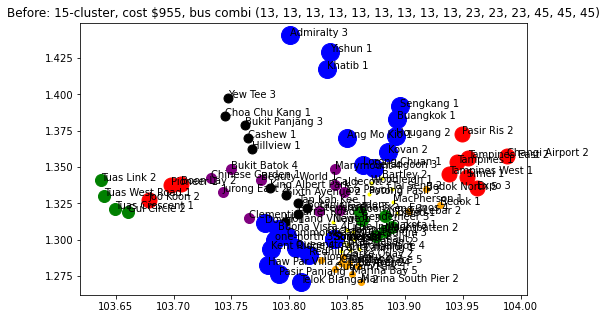

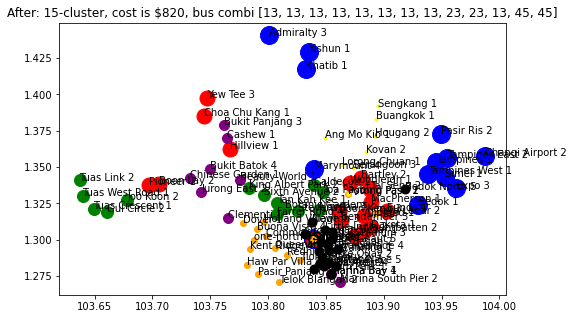

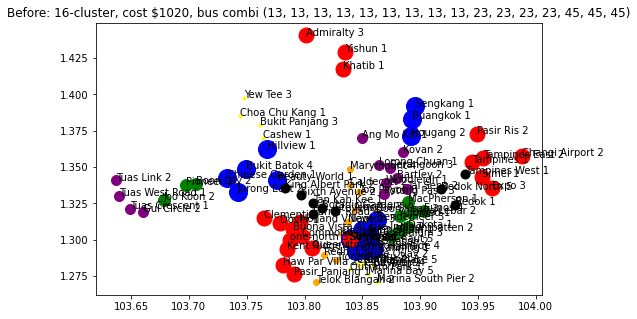

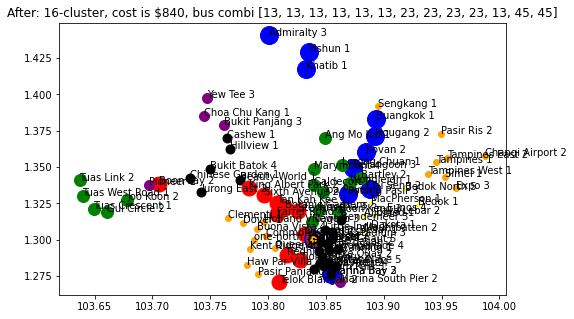

In [33]:
for n_cluster_key in overall_dict.keys():
    n_cluster_dict = overall_dict[n_cluster_key]
    n_cluster_before_dict = before_overall_dict[n_cluster_key]
    
    before_locations_lists = []
    before_locations_with_no_of_ppl_list = []
    before_titles = []
    
    locations_lists = []
    locations_with_no_of_ppl_list = []
    titles = []
    
    # add the before results of this cluster
    for before_cluster_key in n_cluster_before_dict.keys():
        if before_cluster_key != "total_cost" and before_cluster_key != "original_no_of_clusters" and \
                        before_cluster_key != "no_of_clusters" and before_cluster_key != "bus_combi":
            before_cluster_dict = n_cluster_before_dict[before_cluster_key]
            before_locations_lists.append(before_cluster_dict["locations_with_coordinates"])
            before_locations_with_no_of_ppl_list.append(before_cluster_dict["locations_with_no_of_ppl"])
            before_cost = str(n_cluster_before_dict["total_cost"])
            before_bus_combi = str(n_cluster_before_dict["bus_combi"])
            before_titles.append("Before: " + n_cluster_key + ", cost $" + before_cost + ", bus combi " + before_bus_combi)

    
    # add the after results of this cluster
    for cluster_key in n_cluster_dict.keys():
        if cluster_key != "total_cost" and cluster_key != "original_no_of_clusters" and \
                                cluster_key != "no_of_clusters" and cluster_key != "bus_combi":
            cluster_dict = n_cluster_dict[cluster_key]
            locations_lists.append(cluster_dict["locations_with_coordinates"])
            locations_with_no_of_ppl_list.append(cluster_dict["locations_with_no_of_ppl"])
            cost = str(n_cluster_dict["total_cost"])
            bus_combi = str(n_cluster_dict["bus_combi"])
            titles.append("After: " + n_cluster_key + ", cost is $" + cost + ", bus combi " + bus_combi)
            

    display_map(before_locations_lists, before_locations_with_no_of_ppl_list, before_titles)
    display_map(locations_lists, locations_with_no_of_ppl_list, titles)